<a href="https://colab.research.google.com/github/AlexLebada/colab/blob/main/SVM_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

import io
from google.colab import files

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

!pip install scikit-optimize # needed to import skopt
from skopt import BayesSearchCV

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
uploaded = files.upload()

Saving Energy.csv to Energy.csv


In [ ]:
# dataset is time series prroblem
data = pd.read_csv('Energy.csv',index_col=[0])

In [ ]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


####Attribute Information:
* date time year-month-day hour:minute:second
* **Appliances**, energy use in Wh  <-- **Target Variable**
* lights, energy use of light fixtures in the house in Wh
* T1, Temperature in kitchen area, in Celsius
* RH_1, Humidity in kitchen area, in %
* T2, Temperature in living room area, in Celsius
* RH_2, Humidity in living room area, in %
* T3, Temperature in laundry room area
* RH_3, Humidity in laundry room area, in %
* T4, Temperature in office room, in Celsius
* RH_4, Humidity in office room, in %
* T5, Temperature in bathroom, in Celsius
* RH_5, Humidity in bathroom, in %
* T6, Temperature outside the building (north side), in Celsius
* RH_6, Humidity outside the building (north side), in %
* T7, Temperature in ironing room , in Celsius
* RH_7, Humidity in ironing room, in %
* T8, Temperature in teenager room 2, in Celsius
* RH_8, Humidity in teenager room 2, in %
* T9, Temperature in parents room, in Celsius
* RH_9, Humidity in parents room, in %
* To, Temperature outside (from Chievres weather station), in Celsius
* Pressure (from Chievres weather station), in mm Hg
* RH_out, Humidity outside (from Chievres weather station), in %
* Wind speed (from Chievres weather station), in m/s
* Visibility (from Chievres weather station), in km
* Tdewpoint (from Chievres weather station), Â°C
* rv1, Random variable 1, nondimensional
* rv2, Random variable 2, nondimensional

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.694958,102.524891,10.000000,50.000000,60.000000,100.000000,1080.000000
lights,19735.0,3.801875,7.935988,0.000000,0.000000,0.000000,0.000000,70.000000
T1,19735.0,21.686571,1.606066,16.790000,20.760000,21.600000,22.600000,26.260000
RH_1,19735.0,40.259739,3.979299,27.023333,37.333333,39.656667,43.066667,63.360000
T2,19735.0,20.341219,2.192974,16.100000,18.790000,20.000000,21.500000,29.856667
RH_2,19735.0,40.420420,4.069813,20.463333,37.900000,40.500000,43.260000,56.026667
T3,19735.0,22.267611,2.006111,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,19735.0,39.242500,3.254576,28.766667,36.900000,38.530000,41.760000,50.163333
T4,19735.0,20.855335,2.042884,15.100000,19.530000,20.666667,22.100000,26.200000
RH_4,19735.0,39.026904,4.341321,27.660000,35.530000,38.400000,42.156667,51.090000


In [ ]:
data.shape

(19735, 29)

In [ ]:
energy = data.loc[:,'Appliances']
energy.head()

,Appliances
0,60
1,60
2,50
3,50
4,60


## Data partition

In [ ]:
# target variable
e_train, e_test = energy.iloc[:12000], energy.iloc[12000:] # now e_train & e_test are arrays

In [ ]:
e_train.head()

,Appliances
0,60
1,60
2,50
3,50
4,60


In [ ]:
# generate a data matrix for windows series

# Normalize the data
w = 4
scaler = MinMaxScaler()
e_train_s = scaler.fit_transform(e_train.to_numpy().reshape(-1,1)) # to transf. from row vector tot column vector
e_test_s = scaler.fit_transform(e_test.to_numpy().reshape(-1,1))

# Define windows
windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]


In [ ]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

# Support vector machines

## Linear kernel

In [ ]:
# epsilon - insensitive loss ( has to do with margin distance)
# C parameter is for avoid misclassifying training sample
param = {'C': 10**np.linspace(-3,3,101), 'epsilon': np.linspace(0,0.1,11)} # curly brackets define sets

lsvr = SVR(kernel='linear', max_iter=25000, cache_size=2000) # cache_size of kernel (in MB)

lsvr_search = BayesSearchCV(lsvr, param, n_iter = 15, cv=TimeSeriesSplit(n_splits=5, gap=w+1),
                            scoring = make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1,
                            refit=True,random_state=0)

lsvr_search.fit(X_train_w, y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='linear', max_iter=25000),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.5135...
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])})

In [ ]:
show_html(pd.DataFrame(lsvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 0.1445439770745928, 'epsilon': 0.02}",-0.003871,1
13,"{'C': 144.5439770745928, 'epsilon': 0.01}",-0.003911,2
4,"{'C': 0.023988329190194897, 'epsilon': 0.02}",-0.003929,3
2,"{'C': 1.513561248436207, 'epsilon': 0.0}",-0.003962,4
9,"{'C': 0.16595869074375597, 'epsilon': 0.04}",-0.003969,5


## Performance evaluation

In [ ]:
mean_squared_error(y_test_w, lsvr_search.predict(X_test_w)), mean_absolute_error(y_test_w, lsvr_search.predict(X_test_w))

(0.0053905490569200135, 0.029939915794840614)

## Predicttion vs true values

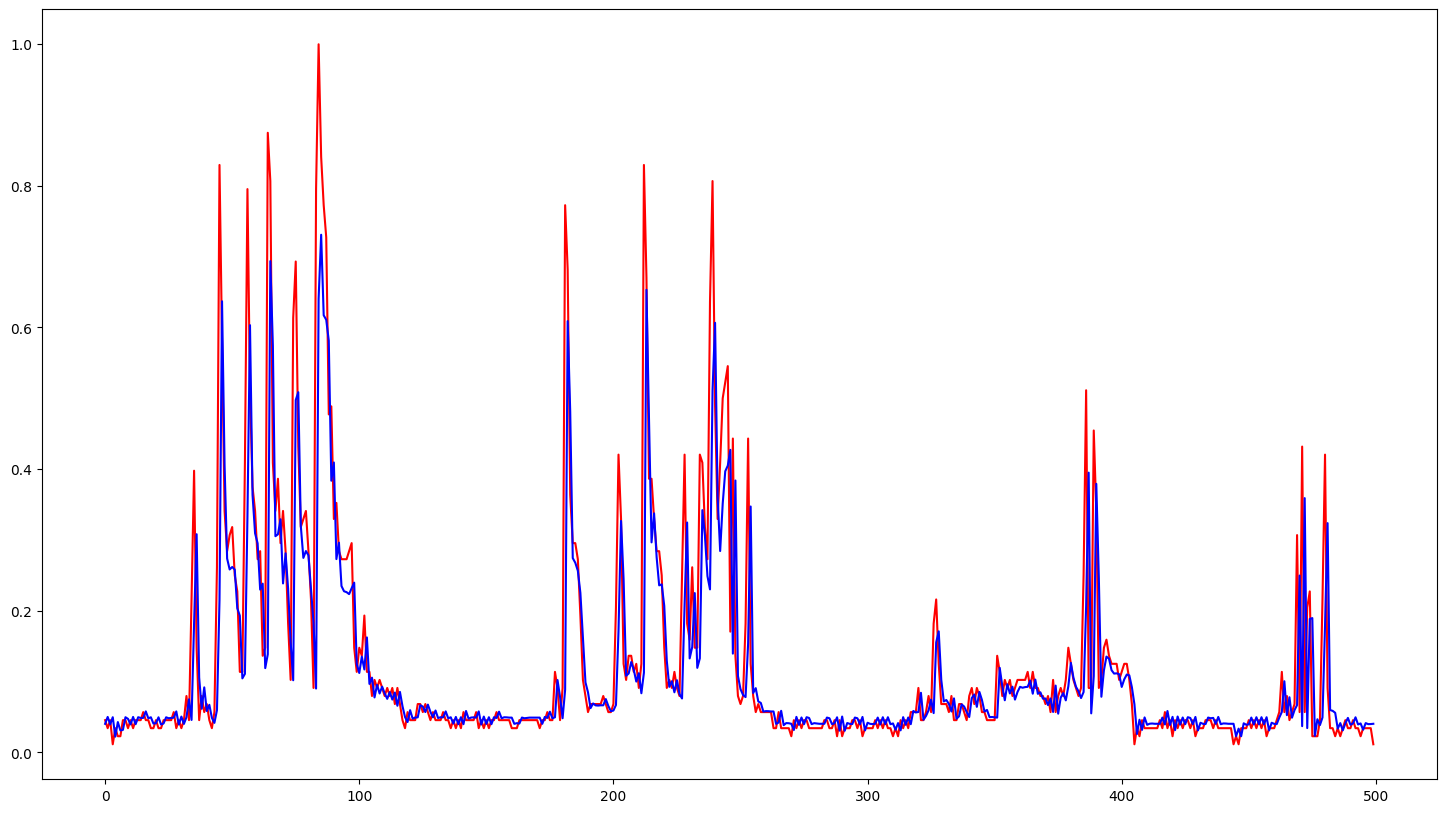

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500], 'r')
plt.plot(lsvr_search.predict(X_test_w[:500]), 'b')

# Polynomial Kernel
  Optimize the param:
* C
* epsilon
* degree

In [ ]:
param = {'C': 10**np.linspace(-3,3,101), 'epsilon': np.linspace(0,0.1,11), 'degree':[2,3,4]} # curly brackets define sets

psvr = SVR(kernel='poly', max_iter=25000, cache_size=2000) # cache_size of kernel (in MB)

psvr_search = BayesSearchCV(psvr, param, n_iter = 15, cv=TimeSeriesSplit(n_splits=5, gap=+1),
                            scoring = make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1,
                            refit=True,random_state=0)

psvr_search.fit(X_train_w, y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='poly', max_iter=25000),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.513561...
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3, 4],
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])})

In [ ]:
show_html(pd.DataFrame(psvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.03}",-0.004749,1
4,"{'C': 0.023988329190194897, 'degree': 2, 'epsilon': 0.08}",-0.005968,2
11,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.08}",-0.006029,3
13,"{'C': 0.047863009232263824, 'degree': 2, 'epsilon': 0.08}",-0.006206,4
2,"{'C': 1.513561248436207, 'degree': 2, 'epsilon': 0.03}",-0.006299,5


## Performance evaluation

In [ ]:
mean_squared_error(y_test_w, psvr_search.predict(X_test_w)), mean_absolute_error(y_test_w, psvr_search.predict(X_test_w))

(0.0067306080153172855, 0.037526457024435814)

## Prediction vs true values

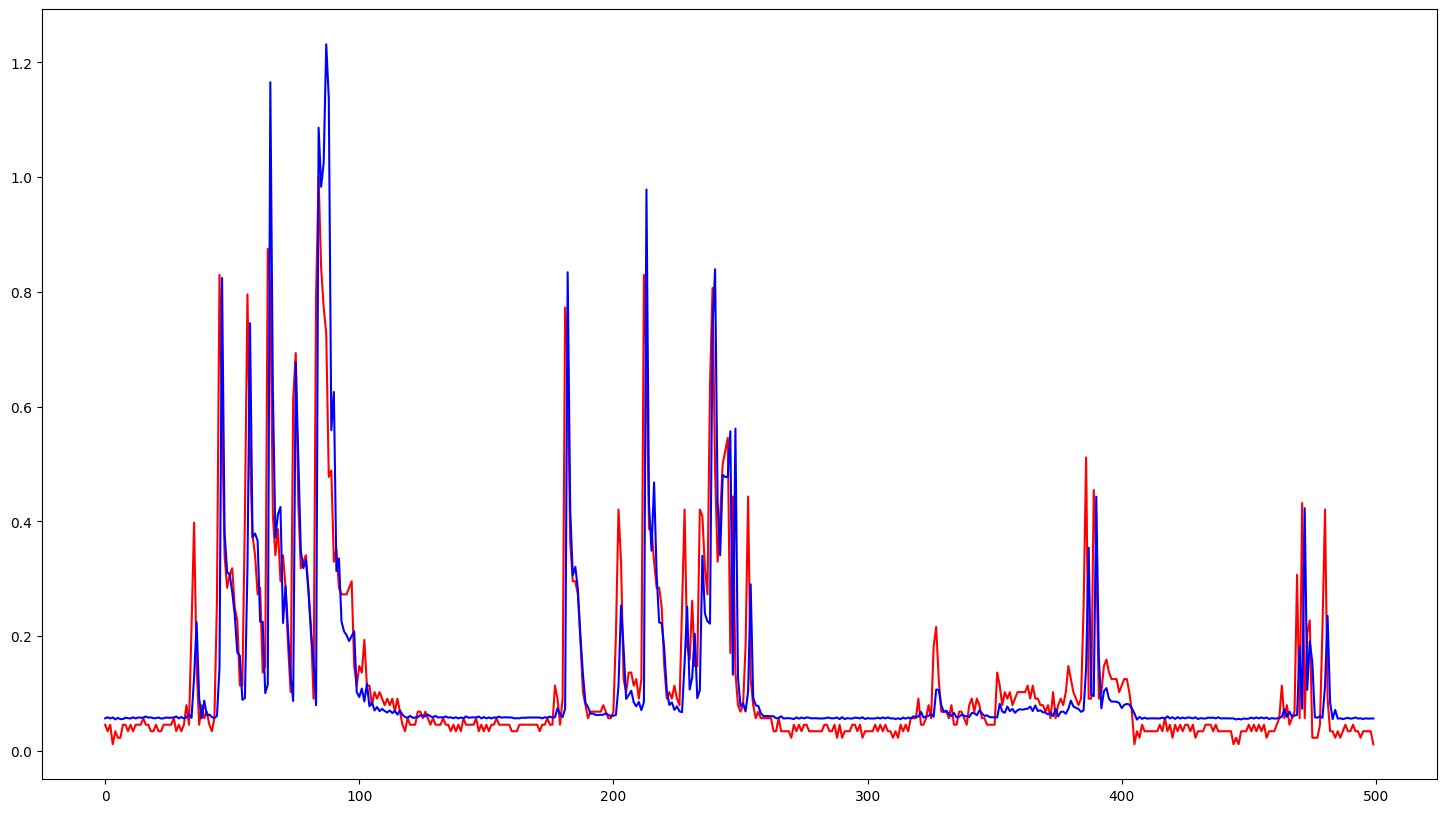

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500], 'r')
plt.plot(psvr_search.predict(X_test_w[:500]), 'b')

# RBF kernel- Radial Basis Function
  Optimize the param
* C regularization strength is inv. proportional with C
* epsilon
* gamma: kernel coef.:
          - scale: 1/(n_features*X.var())
          - auto: 1/ n_features

In [ ]:
param = {'C': 10**np.linspace(-3,3,101), 'epsilon': np.linspace(0,0.1,11), 'gamma':['scale', 'auto']} # curly brackets define sets

rbf_svr = SVR(kernel='rbf', max_iter=25000, cache_size=2000) # cache_size of kernel (in MB)

rbf_svr_search = BayesSearchCV(rbf_svr, param, n_iter = 15, cv=TimeSeriesSplit(n_splits=5, gap=+1),
                            scoring = make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1,
                            refit=True,random_state=0)

rbf_svr_search.fit(X_train_w, y_train_w)

BayesSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, max_iter=25000), n_iter=15,
              n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                             'gamma': ['scale', 'auto']})

In [ ]:
show_html(pd.DataFrame(rbf_svr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 0.1445439770745928, 'epsilon': 0.01, 'gamma': 'scale'}",-0.003695,1
9,"{'C': 0.16595869074375597, 'epsilon': 0.04, 'gamma': 'scale'}",-0.003747,2
11,"{'C': 0.009120108393559097, 'epsilon': 0.03, 'gamma': 'scale'}",-0.003881,3
2,"{'C': 1.513561248436207, 'epsilon': 0.0, 'gamma': 'scale'}",-0.004015,4
4,"{'C': 0.023988329190194897, 'epsilon': 0.02, 'gamma': 'auto'}",-0.004081,5


## Performance evaluation

In [ ]:
mean_squared_error(y_test_w, rbf_svr_search.predict(X_test_w)), mean_absolute_error(y_test_w, rbf_svr_search.predict(X_test_w))

(0.0054678623120772525, 0.02877949330339755)

## Prediction vs true values

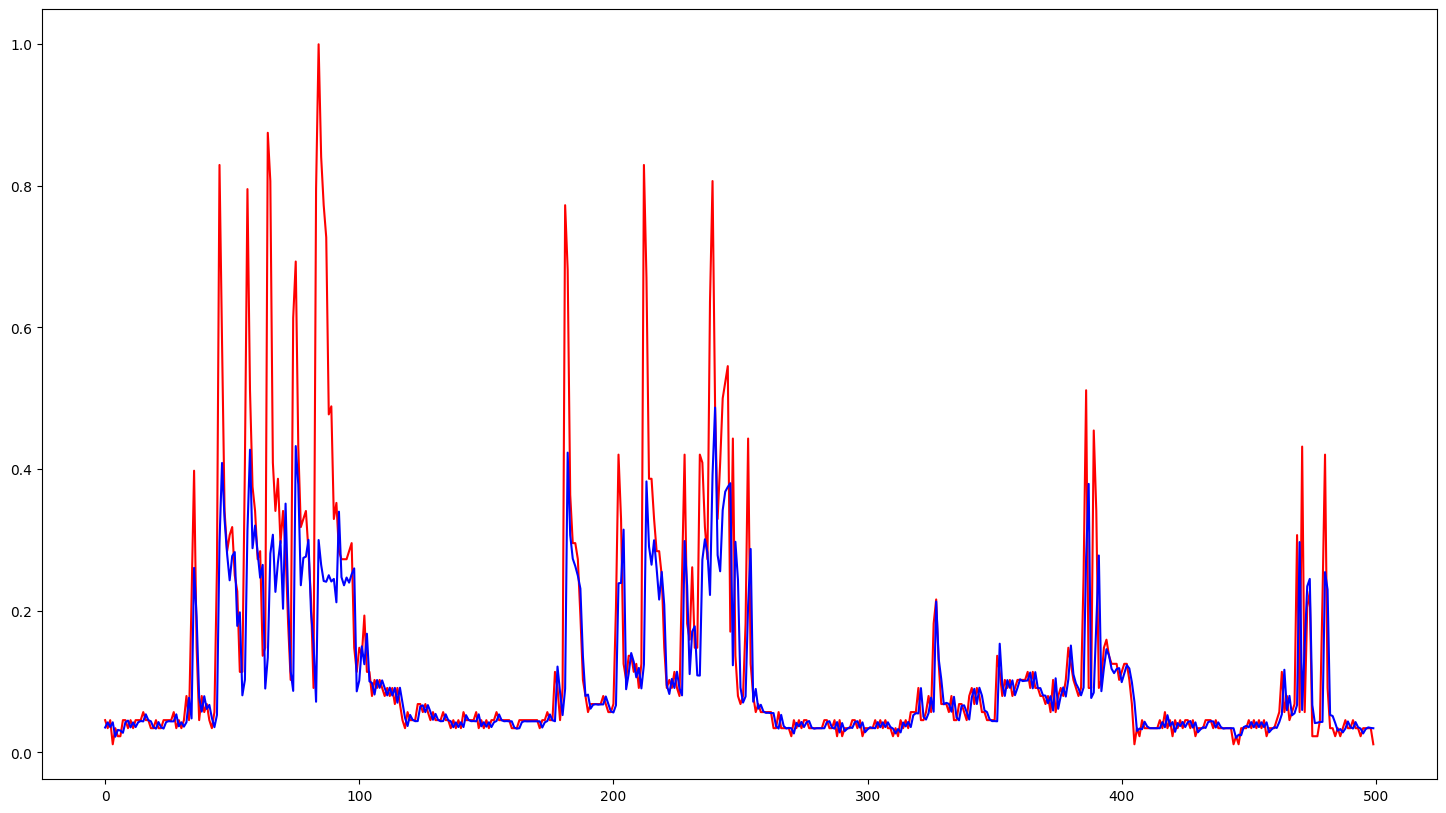

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500], 'r')
plt.plot(rbf_svr_search.predict(X_test_w[:500]), 'b')